In [7]:
import pandas as pd
from google.cloud import storage

from pprint import pprint
import json

Make sure you set your [GOOGLE_APPLICATION_CREDENTIALS variable](https://cloud.google.com/docs/authentication/production#linux-or-macos) to the usage-metrics service account key.

In [8]:
BUCKET_NAME = "github-metrics"

In [9]:
def extract_clones(metric_json):
    return pd.DataFrame(metric_json["clones"])

def extract_views(metric_json):
    return pd.DataFrame(metric_json["views"])

def extract_popular_paths(metric_json):
    return pd.DataFrame(metric_json)

def extract_popular_referrers(metric_json):
    return pd.DataFrame(metric_json)

def extract_stargazers(metric_json):
    trns_metric_json = []
    for stargazer in metric_json:
        user = stargazer["user"]
        starred_at = stargazer["starred_at"]
        user["starred_at"] = starred_at
        trns_metric_json.append(user)
    
    metric_df = pd.DataFrame(trns_metric_json)
    metric_df["starred_at"] = pd.to_datetime(metric_df["starred_at"])
    metric_df = metric_df.set_index("starred_at")
    return metric_df

def extract_forks(metric_json):
    metric_df = pd.DataFrame(metric_json)
    metric_df["created_at"] = pd.to_datetime(metric_df["created_at"])
    metric_df = metric_df.set_index("created_at")
    return metric_df

extract_funcs = {"clones": extract_clones, 
                 "views": extract_views, 
                 "popular_paths": extract_popular_paths, 
                 "popular_referrers": extract_popular_referrers, 
                 "stargazers": extract_stargazers,
                 "forks": extract_forks}

## Persistent Metrics

In [23]:
def plot_cumulative_metric(metric_df, period="M"):
    metric_df.resample(period).count().id.cumsum().plot()

def list_blobs_within_folder(bucket_name, folder):
    """
    Gets blobs within a bucket folder.
    """
    storage_client = storage.Client()

    blobs = list(storage_client.list_blobs(bucket_name, prefix=folder))
    blobs = list(filter(lambda x: x.name != folder, blobs))
    return blobs

def get_recent_persistent_metric(metric):
    """
    Gets a dataframe of the most recent persistent metric data.
    """
    blobs = list_blobs_within_folder(BUCKET_NAME, metric + "/")
    most_recent_blob = sorted(blobs, key=lambda x: x.time_created)[0]
    
    metric_json = json.loads(most_recent_blob.download_as_string())
    extract_func = extract_funcs[metric]
    most_recent_df = extract_func(metric_json)

    return most_recent_df

PERSISTENT_METRICS = ["stargazers", "forks"]

metric_dfs = {}
for metric in PERSISTENT_METRICS:
    metric_dfs[metric] = get_recent_persistent_metric(metric)

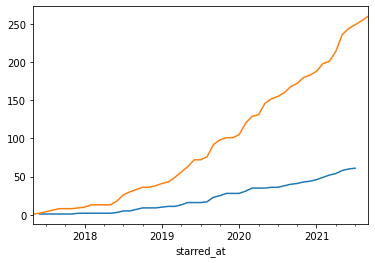

In [24]:
forks = metric_dfs['forks']
stars = metric_dfs["stargazers"]

plot_cumulative_metric(forks)
plot_cumulative_metric(stars)

## Biweekly stats

In [26]:
def get_biweekly_metric(metric):
    blobs = list_blobs_within_folder(BUCKET_NAME, metric + "/")
    
    # get every other week. 
    blobs = sorted(blobs, key=lambda x: x.time_created)
    biweekly_blobs = blobs[::2]
    
    blob_dfs = []
    for blob in biweekly_blobs:
        metric_json = json.loads(blob.download_as_string())
        extract_func = extract_funcs[metric]
        blob_df = extract_func(metric_json)
        
        # Add timestamps to popular paths and referrers
        if "timestamp" not in blob_df.columns:
            blob_df["timestamp"] = blob.time_created
        
        blob_dfs.append(blob_df)
    
    metric_df = pd.concat(blob_dfs)
    return metric_df.set_index("timestamp")
    

BIWEEKLY_METRICS = ["clones", "popular_paths", "popular_referrers", "views"]

for metric in BIWEEKLY_METRICS:
    print(metric)
    metric_dfs[metric] = get_biweekly_metric(metric)

clones
popular_paths
popular_referrers
views


<AxesSubplot:xlabel='timestamp'>

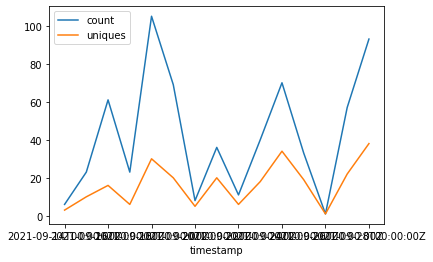

In [27]:
metric_dfs["clones"].plot()

<AxesSubplot:xlabel='timestamp'>

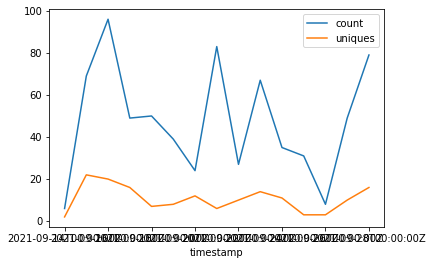

In [28]:
metric_dfs["views"].plot()

In [29]:
metric_dfs["popular_paths"]

,path,title,count,uniques
timestamp,,,,
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl,GitHub - catalyst-cooperative/pudl: The Public...,181,72
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/issues,Issues · catalyst-cooperative/pudl · GitHub,76,8
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/tree/dev,GitHub - catalyst-cooperative/pudl at dev,29,2
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/pulls,Pull requests · catalyst-cooperative/pudl · Gi...,20,4
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/pull/806,Redesign metadata and harvest process by ezwel...,16,2
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/commits/dev,Commits · catalyst-cooperative/pudl,16,1
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/tree/dedupe-metadata,catalyst-cooperative/pudl at dedupe-metadata,10,1
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/tree/redesign-harvest,catalyst-cooperative/pudl at redesign-harvest,10,1
2021-09-28 20:17:37.253000+00:00,/catalyst-cooperative/pudl/pull/1228,Dev PR for sprint ending 2021-09-24 by zanesel...,9,6


In [30]:
metric_dfs["popular_referrers"]

,referrer,count,uniques
timestamp,,,
2021-09-28 20:17:37.546000+00:00,github.com,94,37
2021-09-28 20:17:37.546000+00:00,Google,43,13
2021-09-28 20:17:37.546000+00:00,url.emailprotection.link,15,1
2021-09-28 20:17:37.546000+00:00,catalyst.coop,8,8
2021-09-28 20:17:37.546000+00:00,towardsdatascience.com,8,3
2021-09-28 20:17:37.546000+00:00,com.google.android.gm,7,3
2021-09-28 20:17:37.546000+00:00,catalystcoop-pudl.readthedocs.io,4,4
2021-09-28 20:17:37.546000+00:00,zenodo.org,4,1
2021-09-28 20:17:37.546000+00:00,data.catalyst.coop,2,2
